In [1]:
import psycopg2
import pandas as pd
import os,sys
config_path = os.path.abspath(os.path.join(os.getcwd(), '..','..', 'Loading_Database'))
sys.path.append(config_path)
from configuration import *


In [ ]:
# === SELECT AIRLINES AND RUN EXTRACTION ===
selected_airlines = ["KLM", "British_Airways", "AirFrance", "Lufthansa", "VirginAtlantic" ]   # edit this list
month = None  # or None for all time


In [2]:

# === AIRLINE MAPPING ===
AIRLINE_USER_IDS = {
    56377143: 'KLM',
    106062176: 'AirFrance',
    18332190: 'British_Airways',
    22536055: 'AmericanAir',
    124476322: 'Lufthansa',
    26223583: 'AirBerlin',
    2182373406: 'AirBerlin assist',
    38676903: 'easyJet',
    1542862735: 'RyanAir',
    253340062: 'Singapore',
    20626359: 'VirginAtlantic'
}

# === DB CONNECTION FUNCTION ===
def get_connection():
    return psycopg2.connect(DATABASE_URL)

# === EXTRACTION FUNCTION PER AIRLINE ===
def extract_airline_conversations(user_id, airline_name, month=None):
    # Optional filter for airline reply creation time
    date_filter = ""
    if month:
        date_filter = f"""
        AND t.created_at >= DATE '{month}-01'
        AND t.created_at < (DATE '{month}-01' + INTERVAL '1 month')
        """

    query = f"""
        SELECT
            c.*,
            t.created_at AS tweet_created_at,
            t.senti_raw_tabularis,
            CASE 
                WHEN t.user_id = {user_id} THEN '{airline_name}'
                ELSE 'user'
            END AS author_type
        FROM conversations c
        JOIN tweets t ON c.tweet_id = t.id
        JOIN (
            SELECT DISTINCT c.id
            FROM conversations c
            JOIN tweets t ON c.tweet_id = t.id
            WHERE c.airline_involved = TRUE
              AND t.user_id = {user_id}
              {date_filter}
        ) AS airline_convs ON c.id = airline_convs.id
        WHERE c.airline_involved = TRUE
        ORDER BY c.id, c.position;
    """
    with get_connection() as conn:
        df = pd.read_sql(query, conn)
        return df


In [ ]:

all_dfs = {}

for airline in selected_airlines:
    user_id = next((uid for uid, name in AIRLINE_USER_IDS.items() if name == airline), None)
    if user_id:
        print(f"Extracting {airline} replies in {month or 'ALL TIME'}...")
        df = extract_airline_conversations(user_id, airline, month)
        all_dfs[airline] = df
    else:
        print(f"Unknown airline: {airline}")



Extracting KLM replies in ALL TIME...


C:\Users\pavel\AppData\Local\Temp\ipykernel_17180\1784826188.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Extracting British_Airways replies in ALL TIME...
Extracting AirFrance replies in ALL TIME...
Extracting Lufthansa replies in ALL TIME...
Extracting VirginAtlantic replies in ALL TIME...


In [4]:
import ast

# Custom sentiment label -> score mapping
SENTI_SCORE_MAP = {
    "Very Negative": 0.0,
    "Negative": 0.25,
    "Neutral": 0.5,
    "Positive": 0.75,
    "Very Positive": 1.0
}

def parse_senti(row):
    try:
        senti_dict = ast.literal_eval(row)
        label = senti_dict.get("label")
        return SENTI_SCORE_MAP.get(label, None)
    except:
        return None


In [5]:
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt

# === Label to numeric weight mapping ===
SENTI_SCORE_MAP = {
    "Very Negative": 0.0,
    "Negative": 0.25,
    "Neutral": 0.5,
    "Positive": 0.75,
    "Very Positive": 1.0
}

# === Format counts like 2.3k or 1.2M ===
def format_count(n):
    if n >= 1_000_000:
        return f"{n/1_000_000:.1f}M"
    elif n >= 1_000:
        return f"{n/1_000:.1f}k"
    else:
        return str(n)

# === Parse senti_raw_tabularis into weighted score ===
def parse_senti(row):
    try:
        senti_dict = ast.literal_eval(row)
        label = senti_dict.get("label")
        score = senti_dict.get("score", 0)
        return SENTI_SCORE_MAP.get(label, 0.5) * score
    except:
        return None

# === Extract sentiment label from senti_raw_tabularis ===
def extract_label(row):
    try:
        senti_dict = ast.literal_eval(row)
        return senti_dict.get("label")
    except:
        return None

# === Recompute average sentiment from user-only tweets ===
def compute_avg_sentiment_excl_airline(df):
    df["weighted_score"] = df["senti_raw_tabularis"].apply(parse_senti)
    user_only = df[df["author_type"] == "user"]
    return (
        user_only.groupby("id")["weighted_score"]
        .mean()
        .reset_index()
        .rename(columns={"weighted_score": "avg_senti_score"})
    )

# === Main preparation function ===
def prepare_reply_sentiment_data(df, airline_name):
    df["reply_label"] = df["senti_raw_tabularis"].apply(extract_label)
    df["reply_score"] = df["senti_raw_tabularis"].apply(parse_senti)

    first_reply = (
        df[df["author_type"] == airline_name]
        .sort_values(["id", "position"])
        .groupby("id")
        .first()
        .reset_index()[["id", "position", "reply_label"]]
        .rename(columns={"position": "reply_pos"})
    )

    pos_stats = df.groupby("id")["position"].agg(["min", "max"]).reset_index()
    first_reply = pd.merge(first_reply, pos_stats, on="id", how="left")
    valid_replies = first_reply[first_reply["reply_pos"] < first_reply["max"]].copy()

    valid_replies["reply_type"] = valid_replies["reply_label"].apply(
        lambda x: "Positive" if x in ["Positive", "Very Positive"]
        else "Negative" if x in ["Negative", "Very Negative"]
        else None
    )

    convo_avg = compute_avg_sentiment_excl_airline(df)
    merged = pd.merge(convo_avg, valid_replies[["id", "reply_type"]], on="id", how="inner")
    return merged.dropna(subset=["reply_type"])

# === Process all airlines ===
all_reply_data = []

for airline, df in all_dfs.items():
    print(f"Processing reply sentiment for {airline}")
    reply_df = prepare_reply_sentiment_data(df, airline)
    reply_df["airline"] = airline
    all_reply_data.append(reply_df)

df_violin = pd.concat(all_reply_data, ignore_index=True)


Processing reply sentiment for KLM
Processing reply sentiment for British_Airways
Processing reply sentiment for AirFrance
Processing reply sentiment for Lufthansa
Processing reply sentiment for VirginAtlantic


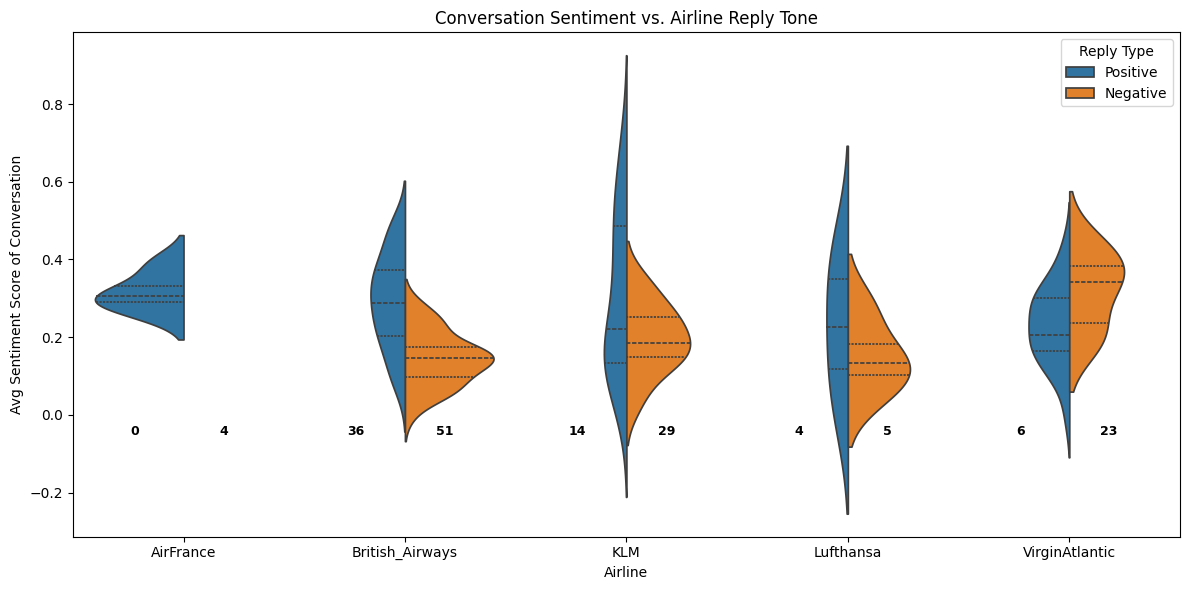

In [6]:

# === Plot with rotated annotations ===


# === Add rotated count annotations inside each violin ===
group_counts = df_violin.groupby(["airline", "reply_type"]).size().unstack().fillna(0)
y_max = df_violin["avg_senti_score"].max()
y_pos = y_max * (-0.06)

plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    data=df_violin,
    x="airline",
    y="avg_senti_score",
    hue="reply_type",
    split=True,
    inner="quartile",
    order= group_counts.index,
    )

for i, airline in enumerate(group_counts.index):
    for reply_type, offset, angle in zip(["Negative", "Positive"], [-0.22, 0.18], [0, 0]):
        count = int(group_counts.loc[airline, reply_type])
        label = format_count(count)
        ax.text(i + offset, y_pos, label, ha="center", va="center", fontsize=9, fontweight="bold", rotation=angle)

# === Final plot polish ===
plt.title("Conversation Sentiment vs. Airline Reply Tone")
plt.ylabel("Avg Sentiment Score of Conversation")
plt.xlabel("Airline")
plt.legend(title="Reply Type", loc="upper right")
plt.tight_layout()
plt.show()


In [7]:
df_violin[df_violin["airline"]== "British_Airways"][df_violin["reply_type"] == "Positive"].count()
for i, airline in enumerate(group_counts.index):
    print(i,airline)
    print(int(group_counts.loc[airline, reply_type]))
group_counts.info()

0 AirFrance
4
1 British_Airways
51
2 KLM
29
3 Lufthansa
5
4 VirginAtlantic
23
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, AirFrance to VirginAtlantic
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Negative  5 non-null      float64
 1   Positive  5 non-null      float64
dtypes: float64(2)
memory usage: 292.0+ bytes


C:\Users\pavel\AppData\Local\Temp\ipykernel_17180\1313311885.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_violin[df_violin["airline"]== "British_Airways"][df_violin["reply_type"] == "Positive"].count()


In [8]:
from scipy.stats import mannwhitneyu
import pandas as pd

def test_significance_per_airline(df_violin):
    results = []
    for airline in df_violin["airline"].unique():
        group = df_violin[df_violin["airline"] == airline]
        pos_scores = group[group["reply_type"] == "Positive"]["avg_senti_score"]
        neg_scores = group[group["reply_type"] == "Negative"]["avg_senti_score"]

        # Only test if both groups have enough samples
        if len(pos_scores) > 10 and len(neg_scores) > 10:
            stat, p = mannwhitneyu(pos_scores, neg_scores, alternative="two-sided")
            pos_mean = pos_scores.mean()
            neg_mean = neg_scores.mean()
            diff = pos_mean - neg_mean
            results.append({
                "airline": airline,
                "positive_mean": round(pos_mean, 3),
                "negative_mean": round(neg_mean, 3),
                "delta": round(diff, 3),
                "p_value": round(p, 5),
                "significant": True if p < 0.01 else False
            })
    return pd.DataFrame(results)
test_significance_per_airline(df_violin)

,airline,positive_mean,negative_mean,delta,p_value,significant
0,KLM,0.305,0.197,0.108,0.23827,False
1,British_Airways,0.293,0.144,0.148,0.00000,True


In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import ast

# === CONFIGURATION ===
NEGATIVITY_THRESHOLD = 0.4  # Below this, conversation is considered negative
SLOPE_THRESHOLD = 0.1       # Above this, it's considered a positive turnaround

# === Sentiment mapping ===
SENTI_SCORE_MAP = {
    "Very Negative": 0.0,
    "Negative": 0.25,
    "Neutral": 0.5,
    "Positive": 0.75,
    "Very Positive": 1.0
}

def extract_score(row):
    try:
        label = ast.literal_eval(row).get("label")
        return SENTI_SCORE_MAP.get(label, None)
    except:
        return None

results = []

for airline, df in all_dfs.items():
    df["senti_score"] = df["senti_raw_tabularis"].apply(extract_score)
    # Convert Created at to Datetime:
    df["tweet_created_at"] = pd.to_datetime(df["tweet_created_at"])
    # Only convo ids where the airline replied
    replied_ids = set(df[df["author_type"] == airline]["id"].unique())

    # Airline's reply hour for each conversation
    airline_reply_times = (
        df[df["author_type"] == airline]
        .sort_values("position")
        .groupby("id")["tweet_created_at"]
        .first()
        .dt.hour
    )
    reply_hour_map = airline_reply_times.to_dict()

    # Relevant user messages
    user_msgs = df[(df["author_type"] == "user") & (df["id"].isin(replied_ids))]
    user_msgs = user_msgs.dropna(subset=["senti_score"])

    # Per-conversation processing
    def process_convo(group):
        if len(group) < 2:
            return None
        convo_id = group["id"].iloc[0]
        start_avg = group.nsmallest(2, "position")["senti_score"].mean()
        if start_avg >= NEGATIVITY_THRESHOLD:
            return None
        x = group["position"].values.reshape(-1, 1)
        y = group["senti_score"].values
        slope = LinearRegression().fit(x, y).coef_[0]
        hour = reply_hour_map.get(convo_id, None)
        return {
            "airline": airline,
            "hour": hour,
            "turned": slope >= SLOPE_THRESHOLD
        }

    group_results = user_msgs.groupby("id").apply(process_convo).dropna().tolist()
    results.extend(group_results)

# === Build DataFrames ===
results_df = pd.DataFrame(results)

df_initial = results_df[["airline", "hour"]].copy()
df_turns = results_df[results_df["turned"]][["airline", "hour"]].copy()

# === Count matrices ===
counts_initial = df_initial.groupby(["hour", "airline"]).size().unstack(fill_value=0)
counts_turn = df_turns.groupby(["hour", "airline"]).size().unstack(fill_value=0)

# === Normalize for fair airline comparison ===
normalized_negative = counts_initial.div(counts_initial.sum(axis=0), axis=1) * 100

# === % of turned conversations out of the negative ones ===
fraction_turned = (counts_turn / counts_initial.replace(0, np.nan)) * 100


C:\Users\pavel\AppData\Local\Temp\ipykernel_17180\1557042518.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["tweet_created_at"] = pd.to_datetime(df["tweet_created_at"])
C:\Users\pavel\AppData\Local\Temp\ipykernel_17180\1557042518.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_results = user_msgs.groupby("id").apply(process_convo).dropna().tolist()
C:\Users\pavel\AppData\Local\Temp\ipykernel_17180\1557042518.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsin

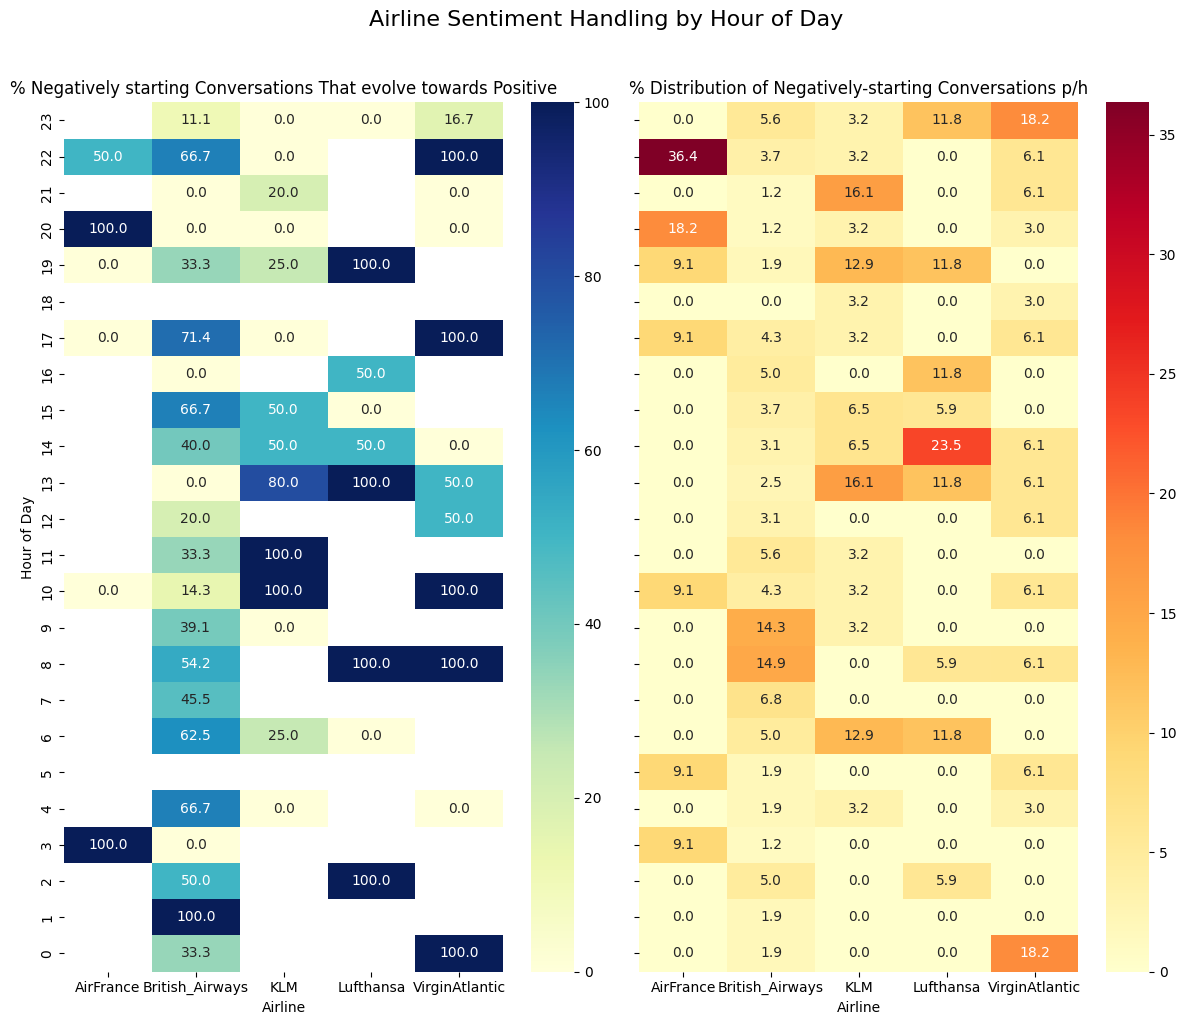

In [10]:

# === Plot ===
fig, axes = plt.subplots(1, 2, figsize=(12, 10), sharey=True)

# Heatmap 1: % of negative conversations that were turned around
sns.heatmap(fraction_turned, ax=axes[0], annot=True, fmt=".1f", cmap="YlGnBu", cbar=True)
axes[0].set_title("% Negatively starting Conversations That evolve towards Positive")
axes[0].set_xlabel("Airline")
axes[0].set_ylabel("Hour of Day")
axes[0].invert_yaxis()
axes[0].tick_params(axis="x", labelrotation=0)

# Heatmap 2: Share of negative starts by hour, normalized across each airline
sns.heatmap(normalized_negative, ax=axes[1], annot=True, fmt=".1f", cmap="YlOrRd", cbar=True)
axes[1].set_title("% Distribution of Negatively-starting Conversations p/h")
axes[1].set_xlabel("Airline")
axes[1].set_ylabel("")
axes[1].invert_yaxis()
axes[1].tick_params(axis="x", labelrotation=0)

plt.suptitle("Airline Sentiment Handling by Hour of Day", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
